**Preparing data:** Run the next cells to download and prepare the datasets and util functions.

In [1]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [2]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [3]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19208gOk2e6cpZ9dxtGF5HKHGYWn01VRo" -O local/datasets/sales.zip && rm -rf /tmp/cookies.txt

In [4]:
if download_data:
    unzip_leaf_dataset()

**Libraries**

In [5]:
import random
import numpy as np
import progressbar
import pandas as pd
import matplotlib.pyplot as plt
import local.lib as lib

from sklearn.ensemble import RandomForestRegressor

from init import dataset_dir

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
_, signals = lib.get_base_dataset(dataset_dir)

In [8]:
month_to_predict = 4
look_back = 3

In [11]:
signals = signals[::900]

In [12]:
results = {}
summary = []

for signal in progressbar.ProgressBar()(signals):
    results.update({signal:{}})
    
    X_train, y_train, i_train, X_test, y_test, i_test = lib.get_split_signal_data(signal, month_to_predict, 
                                                                              look_back, dataset_dir,
                                                                              reshape=False)
    
    model = RandomForestRegressor(max_depth=10, n_jobs=-1)
    model.fit(X_train, y_train)
    
    tr_pred = model.predict(X_train)
    ts_pred = model.predict(X_test)
    
    results[signal].update({"train":tr_pred})
    results[signal].update({"test":ts_pred})
    
    tr_rmse = np.sqrt(((y_train - tr_pred)**2).mean())
    ts_rmse = np.sqrt(((y_test - ts_pred)**2).mean())
    
    summary.append([tr_rmse, ts_rmse])

100% |########################################################################|


In [13]:
summary = pd.DataFrame(summary, columns=["train", "test"], index=signals)

In [14]:
summary.head()

,train,test
2_32,0.467544,0.567647
38_1856,1.616511,0.125747
18_2946,0.482891,0.370981
35_3686,0.475005,0.106000
14_4779,0.872837,0.000000


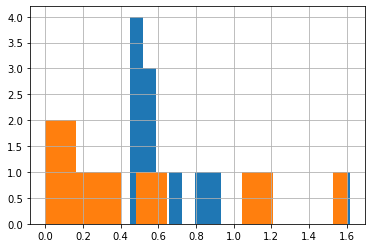

In [15]:
summary.train.hist(bins=20)
summary.test.hist(bins=20)